In [1]:
import torch
import pickle

import torch.nn as nn
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from ds.drivers.datasets import DriverDataset, all_data

In [2]:
ds_step_size = 5
device = "cuda"

figsize = (36, 12)

In [3]:
class ConvX(nn.Module):
    def __init__(
        self, in_planes, out_planes, kernel=3, stride=1, padding=None
    ):
        super(ConvX, self).__init__()
        padding = kernel // 2 if padding is None else padding
        self.conv = nn.Conv1d(
            in_planes,
            out_planes,
            kernel_size=kernel,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.bn = nn.BatchNorm1d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [4]:
class Net6Conv2MaxPool(nn.Module):
    def __init__(self):
        super(Net6Conv2MaxPool, self).__init__()
        self.seq = torch.nn.Sequential(
            ConvX(1, 1, kernel=2, padding=0),
            ConvX(1, 1, kernel=2, padding=0),
            nn.MaxPool1d(2),
            ConvX(1, 1, kernel=2, padding=0),
            ConvX(1, 1, kernel=2, padding=0),
            nn.MaxPool1d(2),
            ConvX(1, 1, kernel=2, padding=0),
            ConvX(1, 1, kernel=2, stride=2),
            nn.Conv1d(1, 1, kernel_size=2),
        )
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        return self.softmax(torch.flatten(self.seq(x), 1))

In [5]:
def val(model, dl_test, return_valid_count_only=True):
    labels_ = []
    outputs_ = []
    with torch.no_grad():
        sum_ = 0
        for i, data in enumerate(dl_test):
            inputs, labels = data
            labels_.append(labels)
            inputs = (
                torch.unsqueeze(inputs, 1).to(torch.float32).to(device=device)
            )
            outputs = model(inputs).cpu()
            outputs = outputs.max(1).indices
            outputs_.append(outputs)
            eq = outputs == labels
            sum_ += eq.sum()

    return sum_ if return_valid_count_only else (sum_, labels_, outputs_)

In [6]:
drivers_test_datasets = {
    driver_id: DriverDataset(
        driver_data,
        ds_type="test",
        data_field="working_data_filtered",
        step=ds_step_size,
    )
    for driver_id, driver_data in all_data.items()
}

In [7]:
def drivers_validate(net_state_dict):
    accuracies = {}
    for driver_id, ds_test in drivers_test_datasets.items():
        dl_test = DataLoader(
            ds_test,
            batch_size=1,
            shuffle=True,
            num_workers=1,
            pin_memory=False,
            drop_last=True,
        )
        net = Net6Conv2MaxPool().to(device=device)
        net.load_state_dict(net_state_dict)
        net.eval()
        accuracy = val(net, dl_test)
        accuracies[driver_id] = accuracy / len(ds_test)
    return accuracies

In [8]:
def net_compute(states_path: Path):
    # with open(net_optim / "acc_hist.csv", newline="") as f:
    #     reader = csv.reader(f)
    #     # skip header
    #     next(reader)
    #     acc = {int(r[1]): float(r[2]) for r in reader}
    hist_state = {}
    for epoch_info_filename in tqdm(states_path.glob("*epoch*.pkl")):
        with open(epoch_info_filename, "rb") as f:
            epoch_info = pickle.load(f)
        hist_state[epoch_info.get("current_epoch")] = {
            "mean": epoch_info.get("rate"),
            "drivers": drivers_validate(epoch_info.get("net_state_dict")),
        }

    for_plot = {
        "mean": [],
        **{id_: [] for id_ in hist_state.get(20).get("drivers").keys()},
    }
    epochs = sorted(hist_state.keys())
    for epoch in epochs:
        values = hist_state[epoch]
        for_plot.get("mean").append(values.get("mean"))
        for driver, value in values.get("drivers").items():
            for_plot.get(driver).append(value.item())
    return epochs, for_plot

In [9]:
def _plt(epochs, for_plot, fig_title, *, figsize=(24, 7)):
    fig, axis = plt.subplots(1, 1, figsize=figsize)
    for title, line in for_plot.items():
        axis.plot(
            epochs, line, label=title, marker="o" if title == "mean" else None
        )
    axis.legend()
    plt.title(fig_title, fontdict={"fontsize": 16})
    plt.xticks(epochs, epochs)
    return plt, axis

In [10]:
epochs_adam, for_plot_adam = net_compute(
    Path("Net6Conv2MaxPool_Adam_lr_0.0001")
)

0it [00:00, ?it/s]

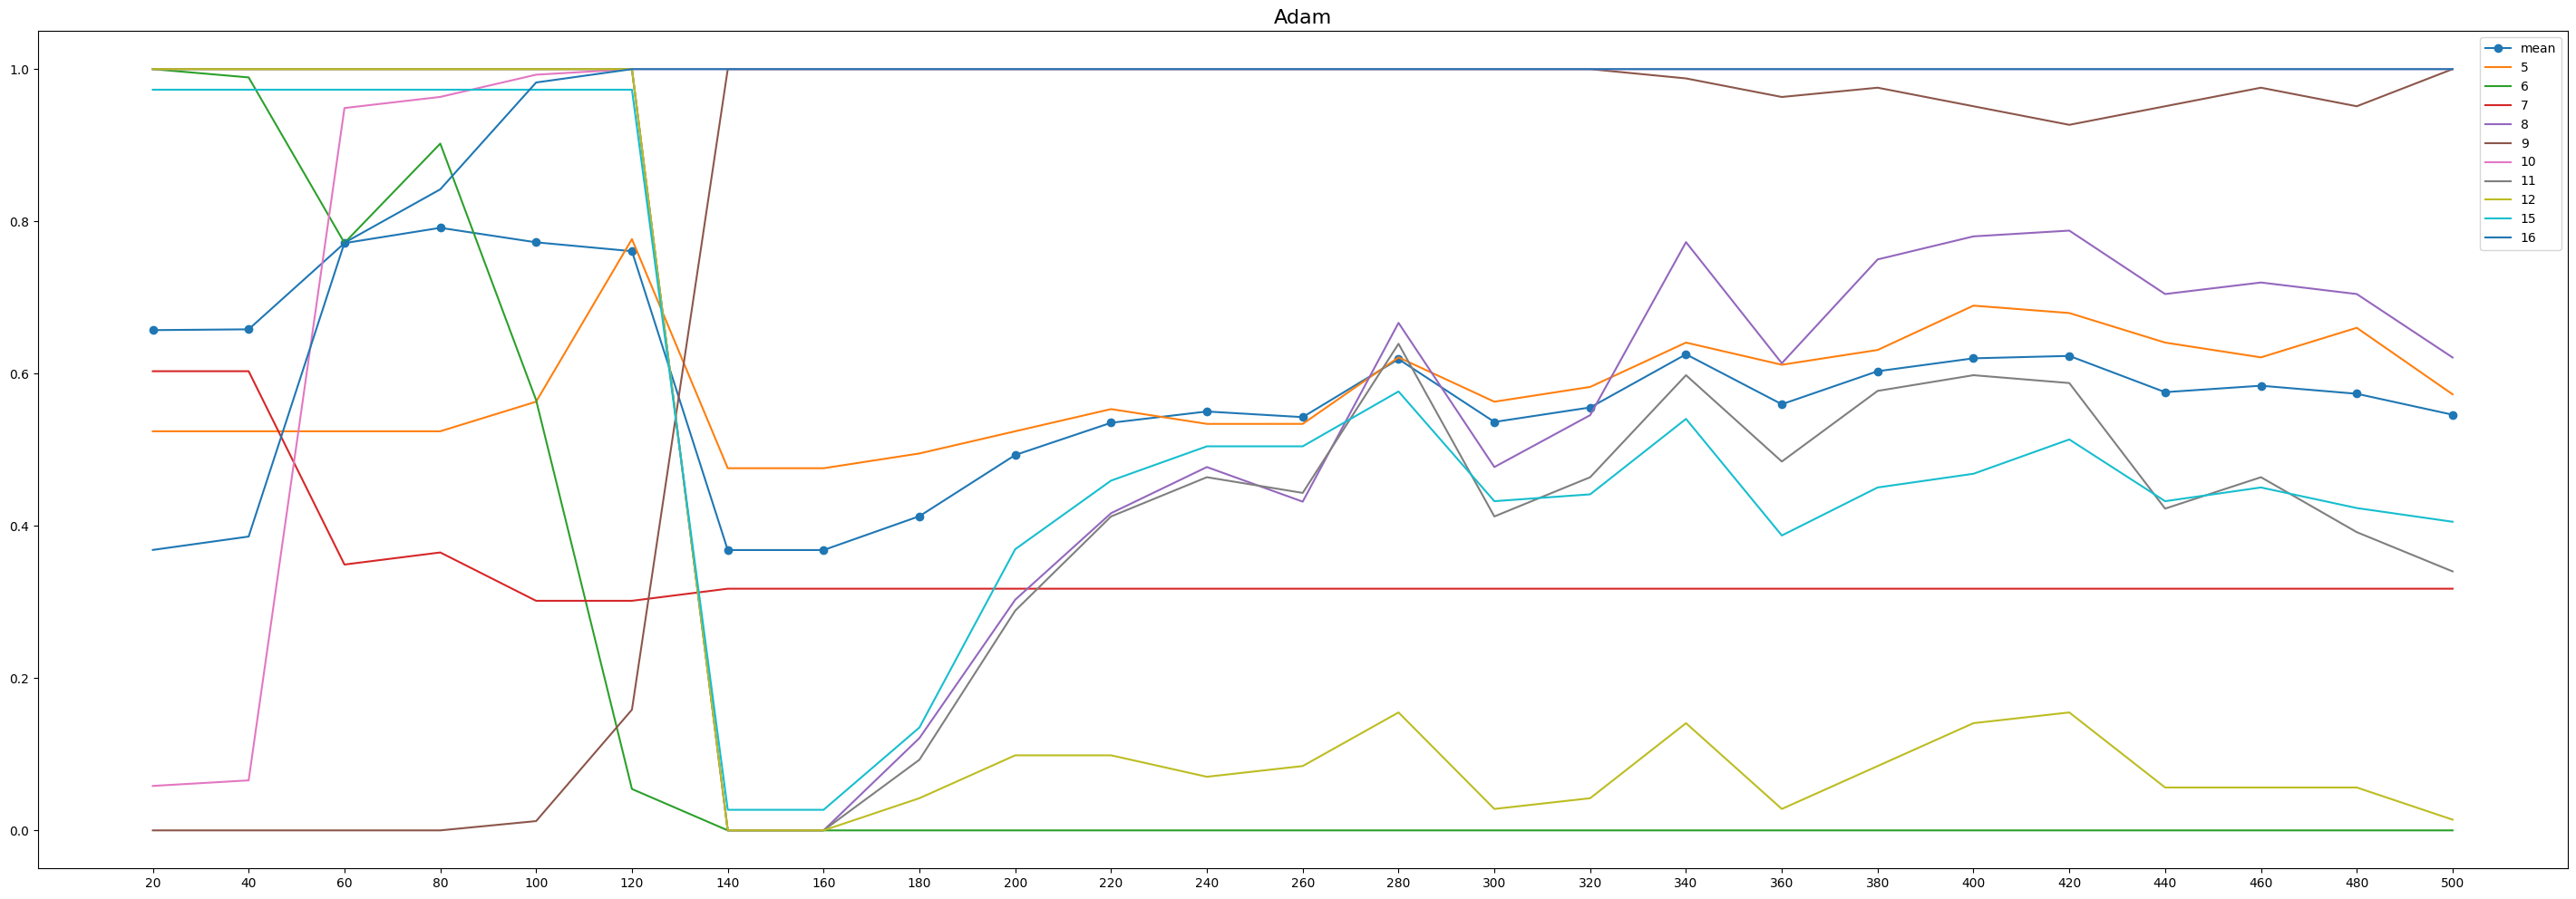

In [11]:
_plt(epochs_adam, for_plot_adam, "Adam", figsize=figsize)
pass

In [12]:
epochs_asgd, for_plot_asgd = net_compute(
    Path("Net6Conv2MaxPool_ASGD_lr_0.0001")
)

0it [00:00, ?it/s]

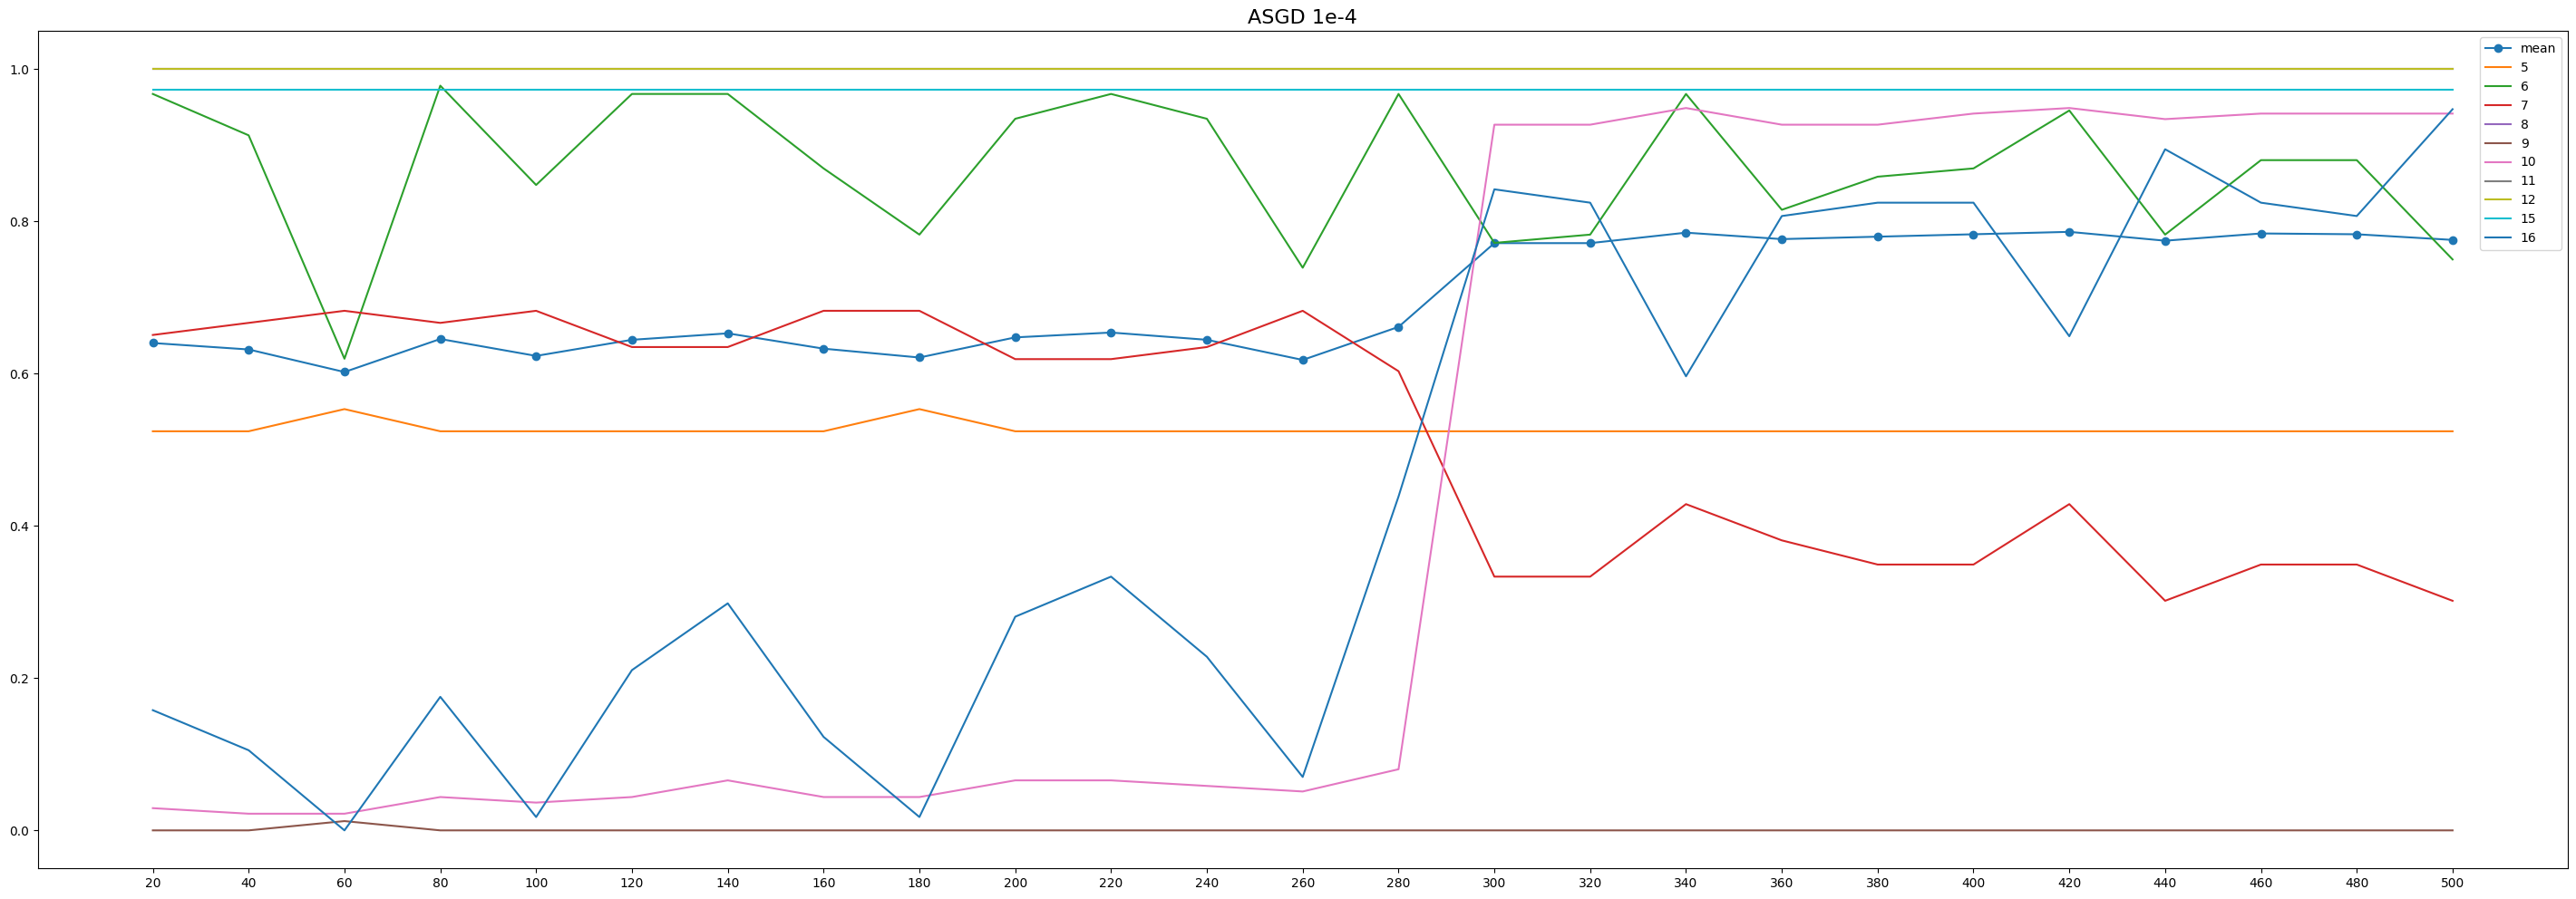

In [13]:
_plt(epochs_asgd, for_plot_asgd, "ASGD 1e-4", figsize=figsize)
pass

In [14]:
epochs_asgd_1e_05, for_plot_asgd_1e_05 = net_compute(
    Path("Net6Conv2MaxPool_ASGD_lr_1e-05")
)

0it [00:00, ?it/s]

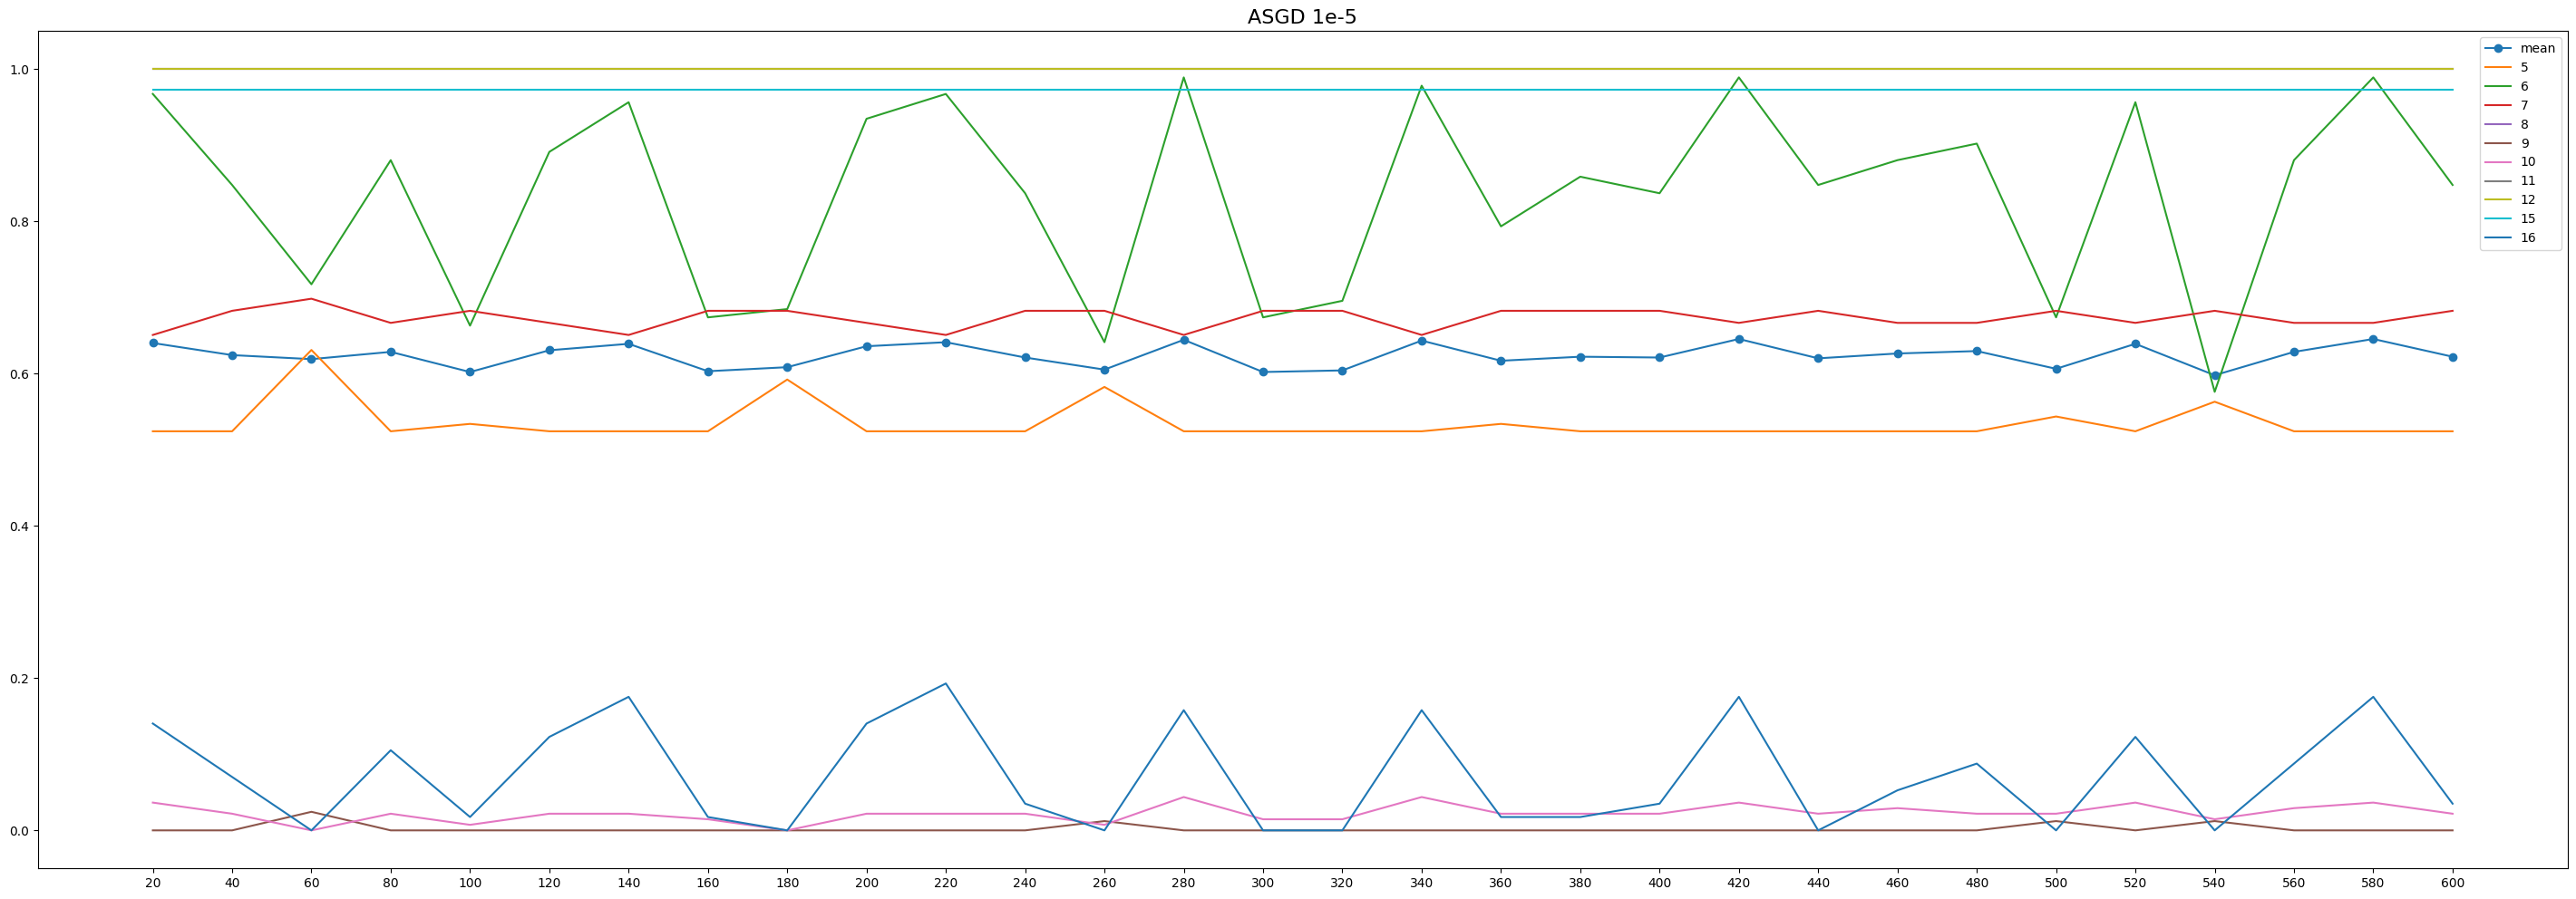

In [15]:
_plt(epochs_asgd_1e_05, for_plot_asgd_1e_05, "ASGD 1e-5", figsize=figsize)
pass

In [16]:
epochs_asgd_5e_05, for_plot_asgd_5e_05 = net_compute(
    Path("Net6Conv2MaxPool_ASGD_lr_5e-05")
)

0it [00:00, ?it/s]

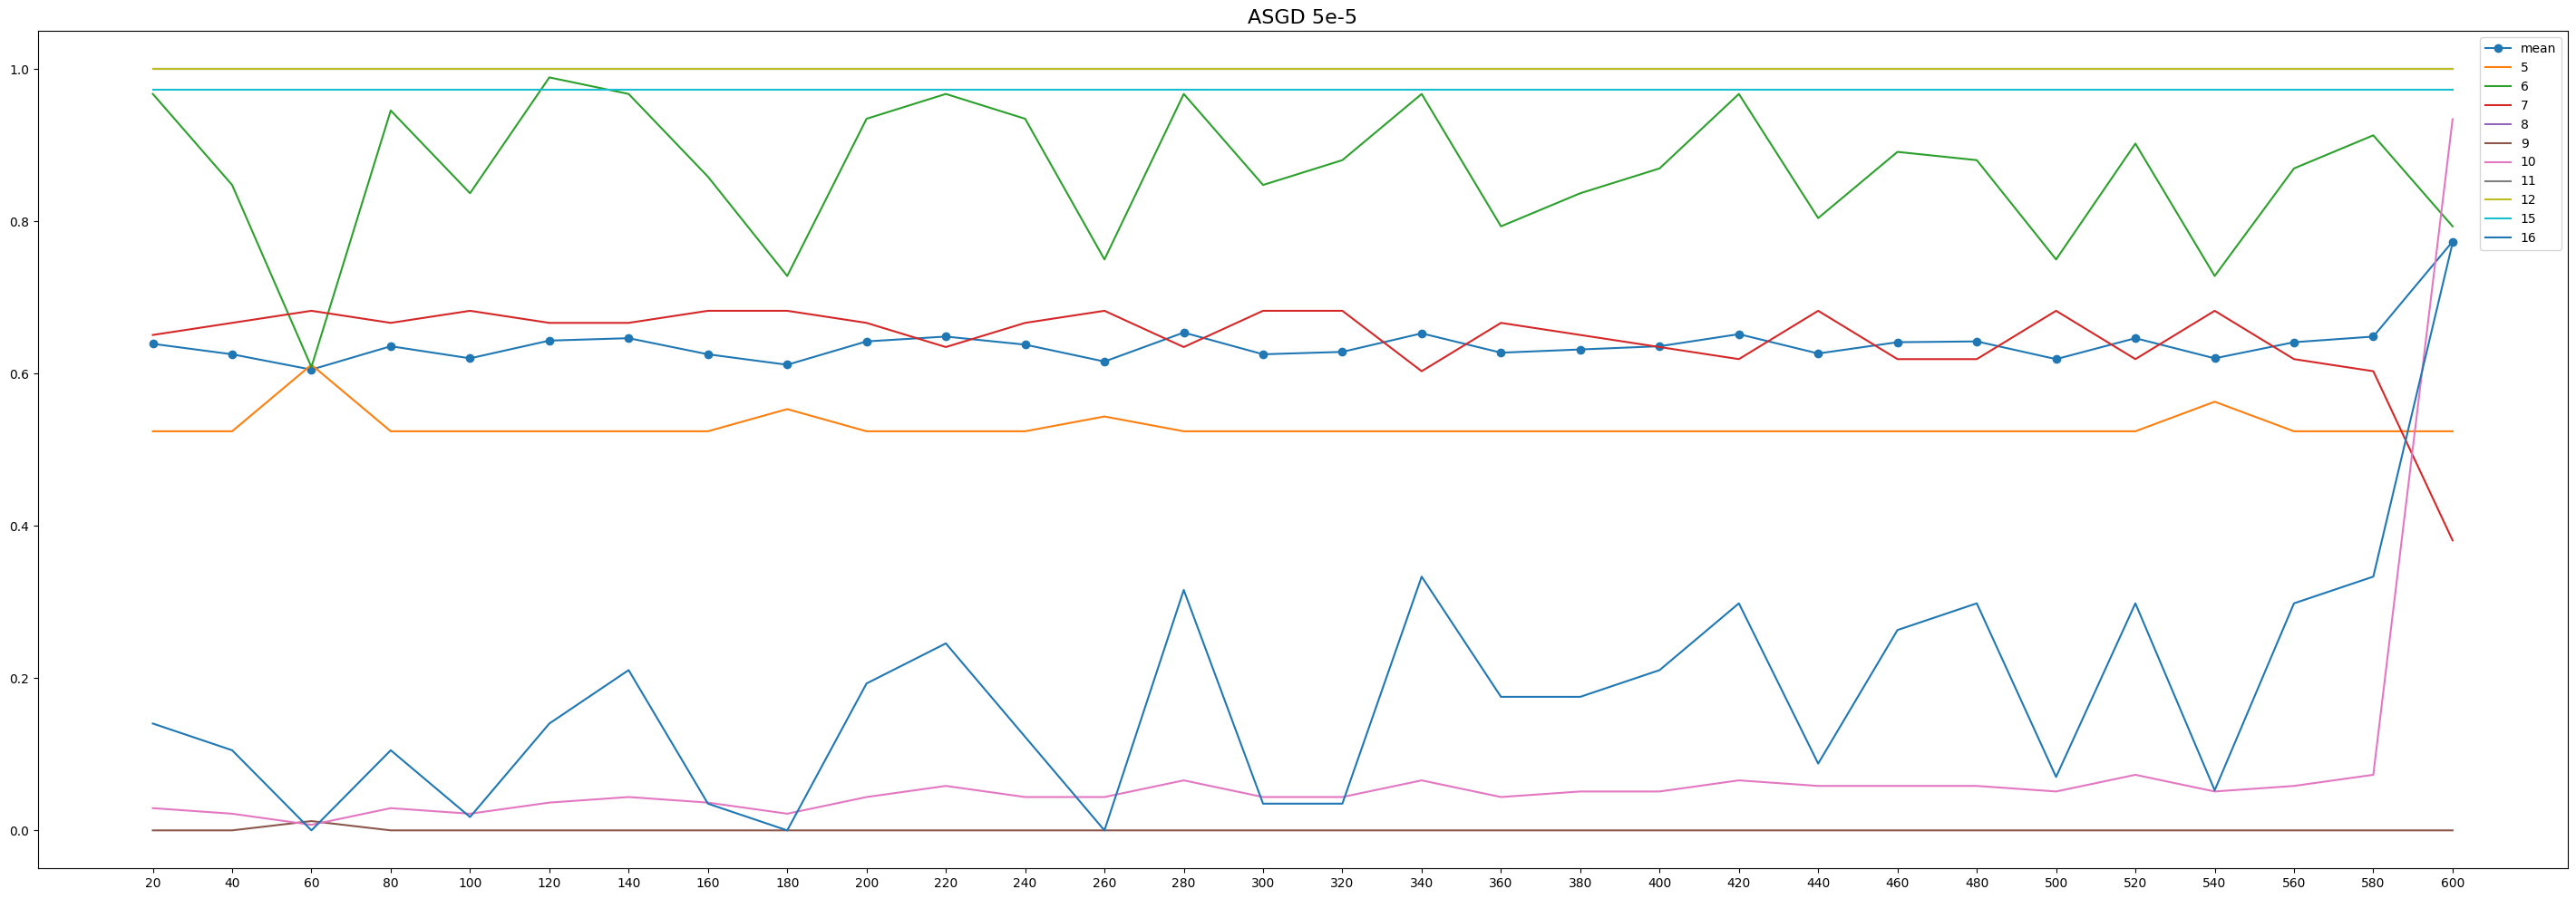

In [17]:
_plt(epochs_asgd_5e_05, for_plot_asgd_5e_05, "ASGD 5e-5", figsize=figsize)
pass

In [18]:
epochs_asgd_075e_05, for_plot_asgd_075e_05 = net_compute(
    Path("Net6Conv2MaxPool_ASGD_lr_7.5e-05")
)

0it [00:00, ?it/s]

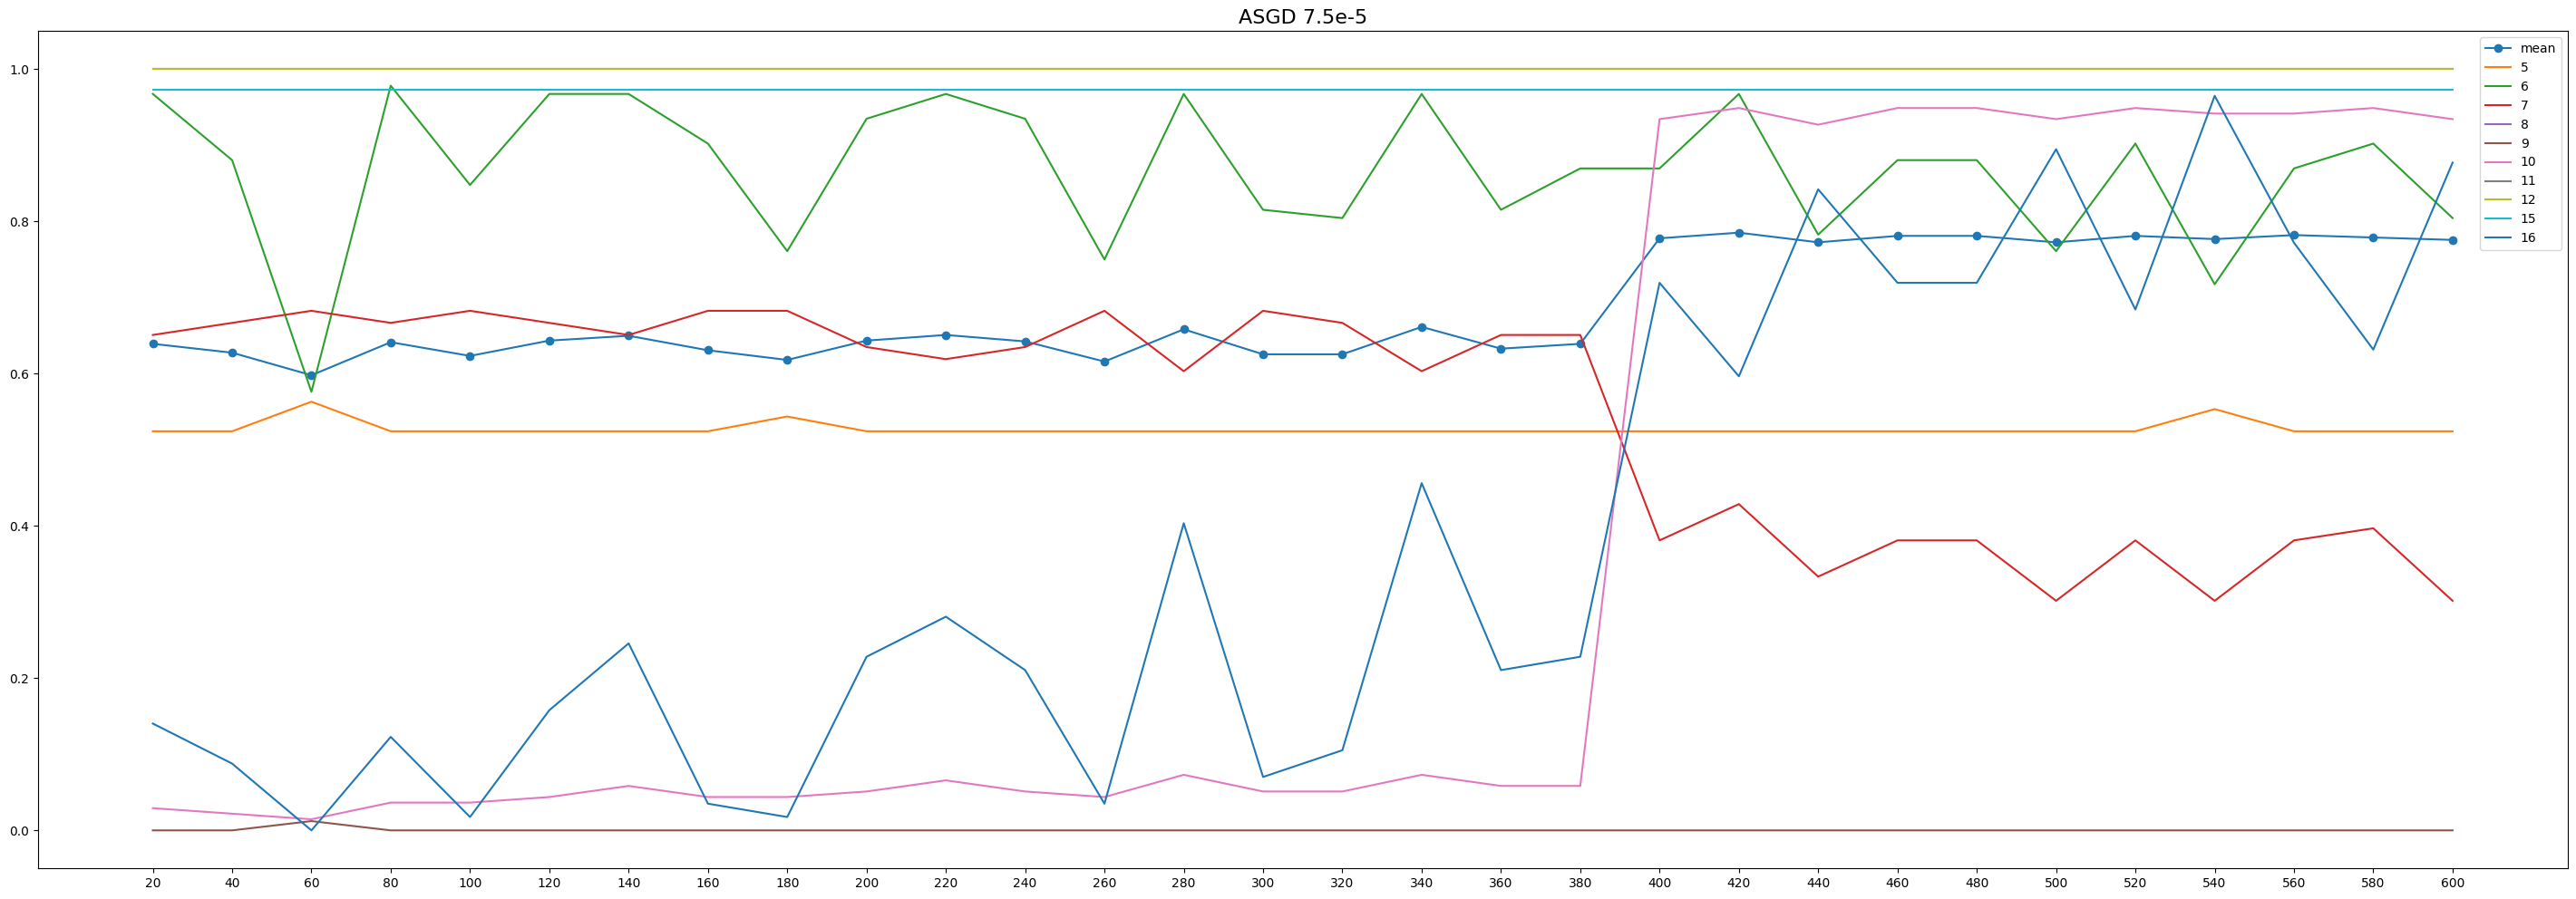

In [19]:
_plt(
    epochs_asgd_075e_05, for_plot_asgd_075e_05, "ASGD 7.5e-5", figsize=figsize
)
pass

---

## Check data

In [53]:
for driver_id, data in all_data.items():
    print(f"{str(driver_id): <2}", end=": ")
    for driver_data in data:
        t = torch.tensor(
            driver_data.get("working_data_filtered").get("RR_list_cor")
        )
        print((round(t.mean().item(), 3), round(t.std().item(), 3)), end="; ")
    print()

5 : (929.066, 79.128); (766.559, 82.724); (748.179, 145.949); (747.46, 86.16); (921.959, 87.523); (800.275, 74.087); (785.493, 57.863); (783.248, 50.915); 
6 : (733.66, 70.644); (514.834, 115.388); (599.689, 107.081); (593.993, 87.271); (661.113, 94.687); (658.342, 64.99); (721.408, 88.268); 
7 : (393.934, 173.291); (435.318, 179.066); (567.924, 219.902); (427.34, 183.356); (838.086, 54.681); (416.182, 194.542); (443.817, 207.047); 
8 : (954.79, 79.839); (579.645, 201.126); (959.653, 65.484); (907.068, 67.581); (974.194, 72.603); (946.072, 86.37); (1015.252, 73.02); 
9 : (913.13, 86.481); (650.652, 174.567); (876.091, 62.57); (867.925, 52.693); (874.415, 57.698); (846.523, 67.465); 
10: (393.269, 166.712); (393.098, 143.375); (375.218, 140.642); (380.478, 145.97); (373.91, 140.124); (381.664, 158.217); (392.577, 166.683); (354.052, 154.113); (376.344, 138.885); (635.796, 127.368); 
11: (982.732, 89.523); (815.297, 84.263); (921.789, 68.151); (881.983, 62.826); (921.379, 46.342); (890.1

In [48]:
train_9 = DriverDataset(
    all_data.get(9),
    ds_type="train",
    data_field="working_data_filtered",
    step=ds_step_size,
)

In [50]:
len(train_9)

328